In [76]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray
import scipy
from scipy.signal import savgol_filter
import xarray
from tqdm import tqdm
import rasterio as rio
import affine
import os
import elevation
import imageio.v2 as imageio
from matplotlib.colors import BoundaryNorm
import geopandas as gpd
from pyproj import Transformer
import matplotlib.colors as mcolors

In [77]:
# load centerline

points = pd.read_csv('centerline_points_100m.csv')
x, y =points.X.to_numpy(), points.Y.to_numpy()

#distance from terminus along centerline 
d = np.linspace(100*len(x), 0, len(x))

print('finished loading centerlines')


finished loading centerlines


In [86]:
# load DEM    
# Open the GeoTIFF file
with rio.open('ifsar_hubbardDEM_reproj.tif') as src:
    # Convert centerline coordinates to pixel indices
    i, j = rio.transform.rowcol(src.transform, x, y)

    # Read the raster data
    data = src.read(1)  # Assuming a single band image
    
    surfdem_centerline = data[i, j]

    # Calculate the resolution (pixel size) of the DEM
    resolution = src.res[0]  # Assuming square pixels
    
    # # Compute gradients using finite differences
    # dz_dx, dz_dy = np.gradient(data, resolution)
    # # Calculate slope magnitude
    # slope_rad = np.arctan(np.sqrt(dz_dx**2 + dz_dy**2))
    # slope_centerline = np.degrees(slope_rad[i,j]) 
    
    # slope along centerline    
    # Compute gradients using finite differences
    dz_dx = np.gradient(data[i,j], resolution)
    # Calculate slope magnitude
    slope_rad = np.arctan(np.sqrt(dz_dx**2))
    slope_centerline = np.degrees(slope_rad)   
    
    n = 10
    slope_centerline = np.convolve(np.ones(n)/n, slope_centerline, mode="same")

print('finished calculating dem and slope along centerline')

finished calculating dem and slope along centerline


In [87]:
# load DEM    

with rio.open('hubbard_bedrock_icebridge_reproj.tif') as src:
    # Convert centerline coordinates to pixel indices
    i, j = rio.transform.rowcol(src.transform, x, y)

    # Read the raster data
    data = src.read(1)  # Assuming a single band image
    
    beddem_centerline = data[i, j]

print('finished calculating bed dem along centerline')

finished calculating bed dem along centerline


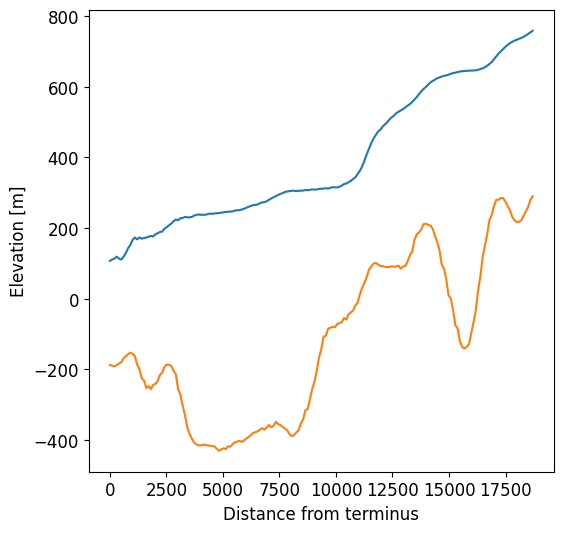

In [88]:

########################
# make figures 
fs = 12 #font size

# fig, ax1 = plt.subplots(figsize=(8, 8))
# ax1.plot(d, slope_centerline)
# ax1.set_xlabel('Distance from terminus', fontsize=fs)
# ax1.set_ylabel('Slope [deg]', fontsize=fs)
# ax1.tick_params(axis='both', which='major', labelsize=fs)

########################
# dem along centerline

fig, ax2 = plt.subplots(figsize=(6, 6))
ax2.plot(d, surfdem_centerline)
ax2.plot(d, beddem_centerline)
ax2.set_xlabel('Distance from terminus', fontsize=fs)
ax2.set_ylabel('Elevation [m]', fontsize=fs)
ax2.tick_params(axis='both', which='major', labelsize=fs)

In [89]:
from scipy.integrate import cumulative_trapezoid

g = 9.81
rhoi = 917
rhow = 1000
H = surfdem_centerline - beddem_centerline
h = surfdem_centerline
Hf = H[-1]
hf= h[-1]
taud = H*dz_dx

Ff = g*rhoi/2*((1-rhow/rhoi)*Hf**2+rhow/rhoi*hf*(2*Hf-hf))
print(f'force acting on terminus ice cliff is', Ff)

force acting on terminus ice cliff is 217460745.92316064


In [115]:
#Difference between Fd at 12 km and 10 km

# Select the interval [10, 12]
mask = (d >= 10000) & (d <= 13000)
#mask = (d >= 0) & (d <= 10000)
d_interval = d[mask]
taud_interval = taud[mask]

# Difference between force per width 
Fd_diff = np.trapz(taud_interval, d_interval)/Ff
print(Fd_diff)

# LARGER DIFFERENCE BETWEEN 10 AND 13 KM THAT FROM 1KM TO 10 KM 

0.007628031821167965


In [91]:
# Compute the cumulative integral using the trapezoidal rule
Fd = cumulative_trapezoid(taud, d, initial=0) + Ff

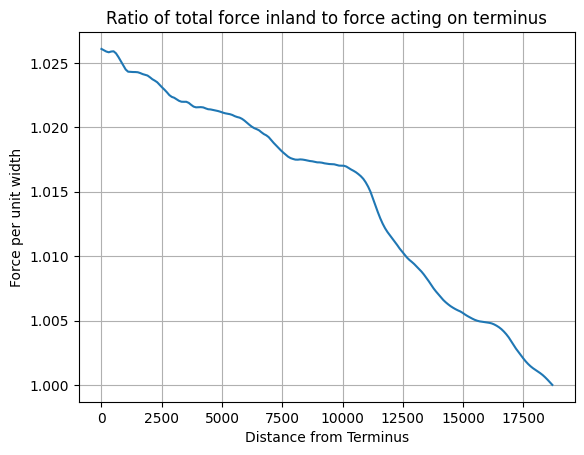

In [92]:


plt.plot(d, Fd/Ff, label='Integral from 0 to x')
plt.xlabel('Distance from Terminus')
plt.ylabel('Force per unit width')
plt.title('Ratio of total force inland to force acting on terminus')
plt.grid(True)
plt.show()